In [397]:
import sklearn
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import pandas as pd
import numpy as np
import math
import sys

from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import multiprocessing

plt.style.use('ggplot')


1.3.1


In [398]:
label_encoder = None 

In [399]:
def get_np_array(file_name):
    global label_encoder
    data = pd.read_csv(file_name)
    
    need_label_encoding = ['team','host','opp','month', 'day_match']
    if(label_encoder is None):
        label_encoder = OrdinalEncoder()
        label_encoder.fit(data[need_label_encoding])
    data_1 = pd.DataFrame(label_encoder.transform(data[need_label_encoding]), columns = label_encoder.get_feature_names_out())
    
    #merge the two dataframes
    dont_need_label_encoding =  ["year","toss","bat_first","format" ,"fow","score" ,"rpo" ,"result"]
    data_2 = data[dont_need_label_encoding]
    final_data = pd.concat([data_1, data_2], axis=1)
    
    X = final_data.iloc[:,:-1]
    y = final_data.iloc[:,-1:]
    return X.to_numpy(), y.to_numpy().flatten()


In [400]:
X_train,y_train = get_np_array('./Dataset/train.csv')
X_test, y_test = get_np_array("./Dataset/test.csv")
X_val, Y_val = get_np_array('./Dataset/val.csv')

types = ['cat','cat','cat',"cat","cat","cont","cat","cat","cat" ,"cont","cont" ,"cont" ]


In [422]:
class DTNode:

    def __init__(self, depth, is_leaf = False, value = 0, column = None, category = None, types = None):

        self.depth = depth
        self.children = None
        self.is_leaf = is_leaf
        self.value = value
        self.column = column
        
        self.category = category
        self.types = types
    
    def __call__(self,X):
        
        if self.is_leaf:
            return self.category

        if self.types[self.column] == 'cat':
            for child in self.children:
                if child.value == X[self.column]:
                    return child(X)
            
            return self.category
        else:
            if X[self.column] <= self.children[0].value:
                return self.children[0](X)
            else:
                return self.children[1](X)

        
        


    def get_children(self, X, y, types, max_depth):
        '''
        Args:
            X: A single example np array [num_features]
        Returns:
            None
        '''
        
        # print("depth", self.depth, "len", len(X))
        
        if self.is_leaf:
            majority = np.sum(y)/len(y)
            if majority > 0.5:
                self.category = 1
            else:
                self.category = 0
                
            return

        
        max_gain = -9999
        max_child_id = None
        
        ids = np.arange(len(types))
        ids = np.random.permutation(ids)
        
        for id in ids:
            type = types[id]
            
            if(type == 'cat'):
                categories = np.unique(X[:,id])
                current_gain = 0
                
                for category in categories:
                    category_indices = np.where(X[:,id] == category)
                    category_y = y[category_indices]
                    
                    positive_count =g np.sum(category_y)
                    negative_count = len(category_y) - positive_count
                    total_count = len(category_y)
                    
                    if positive_count == 0 or negative_count == 0:
                        this_category_gain = 0
                    else:
                        this_category_gain = (positive_count/total_count)*np.log(positive_count/total_count) + (negative_count/total_count)*np.log(negative_count/total_count)
                    
                        
                    current_gain += (total_count/len(y))*this_category_gain

                
                if(current_gain > max_gain):
                    max_gain = current_gain
                    max_child_id = id
                
            else:
                current_gain = 0

                split_accross = np.median(X[:,id])
                split_accross_indices_more = np.where(X[:,id] <= split_accross)
                
                split_accross_indices_more_y = y[split_accross_indices_more]
                
                positive_count = np.sum(split_accross_indices_more_y)
                negative_count = len(split_accross_indices_more_y) - positive_count
                total_count = len(split_accross_indices_more_y)
                
                if positive_count == 0 or negative_count == 0:
                    this_category_gain = 0
                else:
                    this_category_gain = (positive_count/total_count)*np.log(positive_count/total_count) + (negative_count/total_count)*np.log(negative_count/total_count)
                
                
                current_gain += (total_count/len(y))*this_category_gain
                split_accross_indices_less = np.where(X[:,id] > split_accross)
                split_accross_indices_less_y = y[split_accross_indices_less]
                
                positive_count = np.sum(split_accross_indices_less_y)
                negative_count = len(split_accross_indices_less_y) - positive_count
                total_count = len(split_accross_indices_less_y)
                
                if positive_count == 0 or negative_count == 0:
                    this_category_gain = 0
                else:
                    this_category_gain = (positive_count/total_count)*np.log(positive_count/total_count) + (negative_count/total_count)*np.log(negative_count/total_count)
                
                current_gain += (total_count/len(y))*this_category_gain
                
                if(current_gain > max_gain):
                    max_gain = current_gain
                    max_child_id = id
        
        self.column = max_child_id
        self.types = types
        self.category = 1 if np.mean(y) > 0.5 else 0
                
        if types[max_child_id] == 'cat':
            categories = np.unique(X[:,max_child_id])
            children = []
            for category in categories:
                category_indices = np.where(X[:,max_child_id] == category)                
                child = DTNode(self.depth+1,
                                is_leaf = (self.depth >= max_depth),
                                value = category,
                                column=max_child_id,
                                types=types
                                )
                
                child.get_children(X[category_indices], y[category_indices], types, max_depth)

                    
                children.append(child)
            self.children = children
            

            
        else:
            split_accross = np.median(X[:,max_child_id])
            children = [] 
            child = DTNode(self.depth+1,
                            is_leaf = (self.depth >= max_depth),
                            value = split_accross,
                            column=max_child_id,
                            types=types
                            )
            indices = np.where(X[:,max_child_id] <= split_accross)
            child.get_children(X[indices], y[indices], types, max_depth)

            child2 = DTNode(self.depth+1,
                            is_leaf = (self.depth >= max_depth),
                            value = split_accross,
                            column=max_child_id,
                            types=types
                            )
            indices = np.where(X[:,max_child_id] >= split_accross)
            child2.get_children(X[indices], y[indices], types, max_depth)

            
            children.append(child)
            children.append(child2)
            self.children = children
            
    def post_prune(self, X_val, y_val):
        
        if len(X_val) == 0:
            return 0
        # print(len(X_val))
        # assert len(X_val) == len(y_val)
        # assert len(X_val) > 0
        current_accuracy = np.mean(y_val == self.category)

        
        if self.is_leaf:
            return current_accuracy
        
        
        post_prune_accuracy = 0
    
        if self.types[self.column] == 'cat':
            
            categories = np.unique(X_val[:,self.column])
        
            for category in categories:
                filtered_indices = np.where(X_val[:,self.column] == category)
                filtered_X_val = X_val[filtered_indices]
                for child in self.children:
                    if child.value == category:
                        post_prune_accuracy += child.post_prune(filtered_X_val, y_val[filtered_indices]) * len(filtered_X_val)
                        break
                else:
                    post_prune_accuracy += np.mean(y_val[filtered_indices] == self.category) * len(filtered_X_val)
            
            post_prune_accuracy /= len(X_val)
        else:
            
            less_than_indices = np.where(X_val[:,self.column] <= self.children[0].value)
            if len(less_than_indices) > 0:
                less_than_X = X_val[less_than_indices]
                post_prune_accuracy += self.children[0].post_prune(less_than_X, y_val[less_than_indices]) * len(less_than_X)
            
            more_than_indices = np.where(X_val[:,self.column] > self.children[0].value)
            if len(more_than_indices) > 0:
                more_than_X = X_val[more_than_indices]
                post_prune_accuracy += self.children[1].post_prune(more_than_X, y_val[more_than_indices]) * len(more_than_X)
            
            post_prune_accuracy /= len(X_val)
        
    

        if post_prune_accuracy < current_accuracy:
            self.children = None
            self.is_leaf = True
        
        
        return max(post_prune_accuracy, current_accuracy)
        


In [402]:
class DTTree:

    def __init__(self):
        #Tree root should be DTNode
        self.root = DTNode(0)       

    def fit(self, X, y, types, max_depth = 10):
        '''
        Makes decision tree
        Args:
            X: numpy array of data [num_samples, num_features]
            y: numpy array of classes [num_samples, 1]
            types: list of [num_features] with types as: cat, cont
                eg: if num_features = 4, and last 2 features are continious then
                    types = ['cat','cat','cont','cont']
            max_depth: maximum                 this_category_gain = 0
                if positive_count != 0:
                    this_category_gain += (positive_count/total_count)*np.log(positive_count/total_count) 
                elif negative_count != 0:
                    this_category_gain += (negative_count/total_count)*np.log(negative_count/total_count)
                depth of tree
        Returns:
            None
        '''
        self.root.get_children(X, y, types, max_depth)

    def __call__(self, X):
        '''
        Predicted classes for X
        Args:
            X: numpy array of data [num_samples, num_features]
        Returns:
            y:  predicted classes
        '''
        return self.root(X)
    
    def post_prune(self, X_val, y_val):
        self.root.post_prune(X_val, y_val)
        
        
        

In [403]:
max_depth = 5
tree = DTTree()
tree.fit(X_train,y_train,types, max_depth = max_depth)

In [404]:
predictions = []
for i,row in enumerate(X_test):
    predictions.append(tree(row) == y_test[i])
# print(predictions)
print("Accuracy: ", np.sum(predictions)/len(predictions))

Accuracy:  0.5749741468459152


In [405]:
sklearn_tree = DecisionTreeClassifier(criterion='entropy',max_depth=max_depth)
sklearn_tree.fit(X_train,y_train)

val_acc = sklearn_tree.score(X_test,y_test)

print("Validation Accuracy: ", val_acc)

Validation Accuracy:  0.5305067218200621


In [406]:
print(f"Only win prediction accuracy is {np.sum(y_test)/len(y_test)}")
print(f"Only loss prediction accuracy is {1 - np.sum(y_test)/len(y_test)}")

Only win prediction accuracy is 0.4963805584281282
Only loss prediction accuracy is 0.5036194415718718


In [407]:
def calculate_accuracies_for_given_depth(max_depth, X_train, y_train, X_test, y_test, types):
    
    tree = DTTree()
    tree.fit(X_train, y_train, types, max_depth=max_depth)
    
    train_predictions = [tree(row) for row in X_train]
    train_accuracy = np.sum(train_predictions == y_train) / len(y_train)
    
    test_predictions = [tree(row) for row in X_test]
    test_accuracy = np.sum(test_predictions == y_test) / len(y_test)
    
    print(f'Ran for max_depth = {max_depth}, got {train_accuracy} train accuracy and {test_accuracy} test accuracy')
    
    return train_accuracy, test_accuracy

In [408]:
# max_depths = [5, 10]
max_depths = [i + 1 for i in range(25)]

num_cores = multiprocessing.cpu_count()

pool = multiprocessing.Pool(processes=num_cores)
results = pool.starmap(calculate_accuracies_for_given_depth, [(max_depth, X_train, y_train, X_test, y_test, types) for max_depth in max_depths])
pool.close()
pool.join()

train_accuracies, test_accuracies = zip(*results)

Ran for max_depth = 5, got 0.9239810910949278 train accuracy and 0.5739400206825233 test accuracy
Ran for max_depth = 10, got 0.9897789702312508 train accuracy and 0.5915201654601862 test accuracy


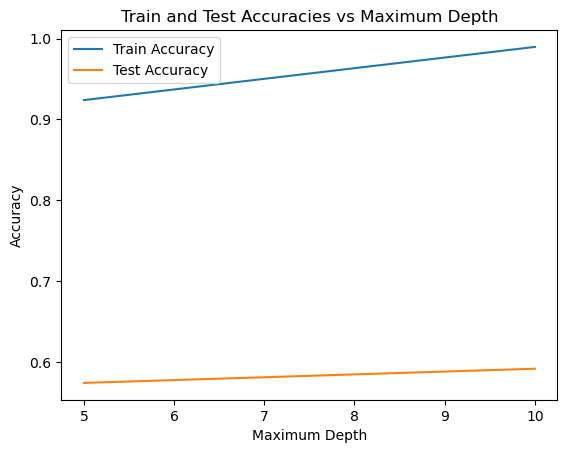

In [409]:
plt.plot(max_depths, train_accuracies, label='Train Accuracy')
plt.plot(max_depths, test_accuracies, label='Test Accuracy')
plt.xlabel('Maximum Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Test Accuracies vs Maximum Depth')
plt.show()

In [410]:

one_hot_encoder = OneHotEncoder()
train_data_pd = pd.read_csv('./Dataset/train.csv')
need_label_encoding = ['team','host','opp','month', 'day_match']
one_hot_encoder.fit(train_data_pd[need_label_encoding])

print(one_hot_encoder.categories_)

def get_np_array_as_one_hot_encode(file_name):
    data = pd.read_csv(file_name)
    
    y_out = data['result']
    y_out = y_out.values

    
    data_left = data[need_label_encoding]
    data_left = data_left.values
    data_1 = one_hot_encoder.transform(data_left)

    
    dont_need_label_encoding =  ["year","toss","bat_first","format" ,"fow","score" ,"rpo"]
    data_2 = data[dont_need_label_encoding]
    data_2 = data_2.values
    
    X = np.hstack((data_1.toarray(), data_2))
    
    return X, y_out

[array(['afganistan', 'australia', 'bangladesh', 'bermuda', 'canada',
       'england', 'india', 'ireland', 'kenya', 'netherlands',
       'new_zealand', 'pakistan', 'scotland', 'south_africa', 'sri_lanka',
       'uae', 'usa', 'west_indis', 'zimbambave'], dtype=object), array(['australia', 'bangladesh', 'bermuda', 'canada', 'england', 'india',
       'ireland', 'kenya', 'malaysia', 'netherlands', 'new_zealand',
       'pakistan', 'scotland', 'south_africa', 'sri_lanka', 'uae', 'usa',
       'west_indis', 'zimbambave'], dtype=object), array(['afganistan', 'australia', 'bangladesh', 'bermuda', 'canada',
       'england', 'india', 'ireland', 'kenya', 'netherlands',
       'new_zealand', 'pakistan', 'scotland', 'south_africa', 'sri_lanka',
       'uae', 'usa', 'west_indis', 'zimbambave'], dtype=object), array(['apr', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may',
       'nov', 'oct', 'sep'], dtype=object), array([0, 1, 2])]


In [411]:
X_train,y_train = get_np_array_as_one_hot_encode('./Dataset/train.csv')
X_test, y_test = get_np_array_as_one_hot_encode("./Dataset/test.csv")
X_val, y_val = get_np_array_as_one_hot_encode('./Dataset/val.csv')


types = ['cat' for _ in range(72)]

types = types + ["cont","cat","cat","cat" ,"cont","cont" ,"cont" ]

/home/higgsboson/anaconda3/envs/733/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/home/higgsboson/anaconda3/envs/733/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/home/higgsboson/anaconda3/envs/733/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


In [412]:
def calculate_accuracies_for_given_depth_one_hot(max_depth, X_train, y_train, X_test, y_test, types):
    
    tree = DTTree()
    tree.fit(X_train, y_train, types, max_depth=max_depth)
    
    train_predictions = [tree(row) for row in X_train]
    train_accuracy = np.sum(train_predictions == y_train) / len(y_train)
    
    test_predictions = [tree(row) for row in X_test]
    test_accuracy = np.sum(test_predictions == y_test) / len(y_test)
    
    print(f'Ran for max_depth = {max_depth}, got {train_accuracy} train accuracy and {test_accuracy} test accuracy')
    
    return train_accuracy, test_accuracy

In [413]:
max_depths = [5*(i + 1) for i in range(12)]

num_cores = multiprocessing.cpu_count()

pool = multiprocessing.Pool(processes=num_cores)
results = pool.starmap(calculate_accuracies_for_given_depth_one_hot, [(max_depth, X_train, y_train, X_test, y_test, types) for max_depth in max_depths])
pool.close()
pool.join()

train_accuracies_one_hot, test_accuracies_one_hot = zip(*results)

Ran for max_depth = 5, got 0.5871981602146417 train accuracy and 0.5532574974146846 test accuracy
Ran for max_depth = 10, got 0.634598185767216 train accuracy and 0.5687693898655636 test accuracy


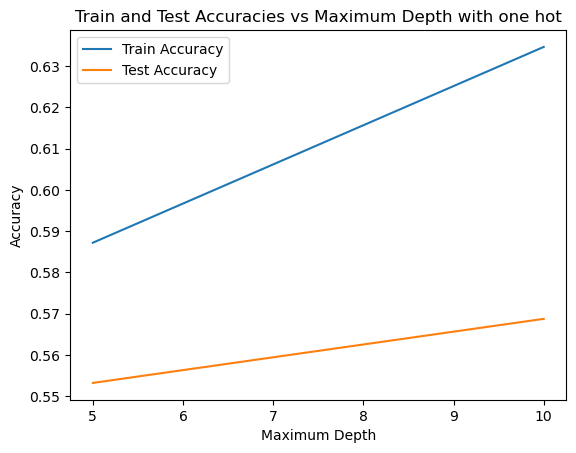

In [414]:
plt.plot(max_depths, train_accuracies_one_hot, label='Train Accuracy')
plt.plot(max_depths, test_accuracies_one_hot, label='Test Accuracy')
plt.xlabel('Maximum Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Test Accuracies vs Maximum Depth with one hot')
plt.show()

In [415]:
def calculate_accuracies_for_given_depth_sklearn(max_depth, X_train, y_train, X_test, y_test, types):

    sklearn_tree = DecisionTreeClassifier(criterion='entropy',max_depth=max_depth)
    sklearn_tree.fit(X_train,y_train)

    train_accuracy = sklearn_tree.score(X_train,y_train)
    test_accuracy = sklearn_tree.score(X_test,y_test)

    print(f'Ran for max_depth = {max_depth}, got {train_accuracy} train accuracy and {test_accuracy} test accuracy')
    
    return train_accuracy, test_accuracy

In [416]:
# max_depths = [5, 10, 15, 20, 25]
max_depths = [i + 1 for i in range(40)]

num_cores = multiprocessing.cpu_count()

pool = multiprocessing.Pool(processes=num_cores)
results = pool.starmap(calculate_accuracies_for_given_depth_sklearn, [(max_depth, X_train, y_train, X_test, y_test, types) for max_depth in max_depths])
pool.close()
pool.join()

train_accuracies_sklearn, test_accuracies_sklearn = zip(*results)

Ran for max_depth = 1, got 0.5344320940334739 train accuracy and 0.5180972078593589 test accuracy
Ran for max_depth = 2, got 0.536604062859333 train accuracy and 0.5211995863495347 test accuracy
Ran for max_depth = 3, got 0.5608790085601124 train accuracy and 0.5170630816959669 test accuracy
Ran for max_depth = 4, got 0.5612622971764405 train accuracy and 0.5170630816959669 test accuracy
Ran for max_depth = 5, got 0.5694391209914399 train accuracy and 0.5542916235780765 test accuracy
Ran for max_depth = 6, got 0.5870703973425323 train accuracy and 0.5573940020682523 test accuracy
Ran for max_depth = 7, got 0.6016353647629998 train accuracy and 0.6028955532574974 test accuracy
Ran for max_depth = 8, got 0.6137728376133895 train accuracy and 0.5884177869700103 test accuracy
Ran for max_depth = 9, got 0.6238661045100294 train accuracy and 0.5997931747673216 test accuracy
Ran for max_depth = 10, got 0.6407308036284656 train accuracy and 0.6028955532574974 test accuracy
Ran for max_depth = 

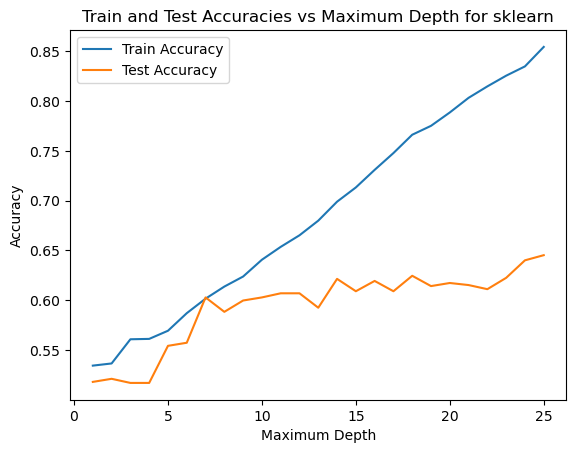

In [417]:
plt.plot(max_depths, train_accuracies_sklearn, label='Train Accuracy')
plt.plot(max_depths, test_accuracies_sklearn, label='Test Accuracy')
plt.xlabel('Maximum Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Test Accuracies vs Maximum Depth for sklearn')
plt.show()

In [430]:
# tree = DTTree()
# tree.fit(X_train, y_train, types, max_depth=10)

# # tree.post_prune(X_val, Y_val)

# train_predictions = [tree(row) for row in X_train]
# train_accuracy = np.sum(train_predictions == y_train) / len(y_train)

# test_predictions = [tree(row) for row in X_test]
# test_accuracy = np.sum(test_predictions == y_test) / len(y_test)

# print(f'Ran for max_depth = {max_depth}, got {train_accuracy} train accuracy and {test_accuracy} test accuracy')


Ran for max_depth = 5, got 0.6228440015331544 train accuracy and 0.5594622543950362 test accuracy


In [424]:
def calculate_accuracies_for_given_depth_with_pruning(max_depth, X_train, y_train, X_val, Y_val, X_test, y_test, types):
    
    tree = DTTree()
    tree.fit(X_train, y_train, types, max_depth=max_depth)
    
    tree.post_prune(X_val, Y_val)
    
    train_predictions = [tree(row) for row in X_train]
    train_accuracy = np.sum(train_predictions == y_train) / len(y_train)
    
    test_predictions = [tree(row) for row in X_test]
    test_accuracy = np.sum(test_predictions == y_test) / len(y_test)
    
    print(f'Ran for max_depth = {max_depth}, got {train_accuracy} train accuracy and {test_accuracy} test accuracy')
    
    return train_accuracy, test_accuracy

In [432]:
max_depths = [5*(i + 1) for i in range(12)]

num_cores = multiprocessing.cpu_count()

pool = multiprocessing.Pool(processes=num_cores)
results = pool.starmap(calculate_accuracies_for_given_depth_with_pruning, [(max_depth, X_train, y_train, X_val, y_val, X_test, y_test, types) for max_depth in max_depths])
pool.close()
pool.join()

train_accuracies_prune, test_accuracies_prune = zip(*results)

Ran for max_depth = 5, got 0.5857927686214386 train accuracy and 0.5532574974146846 test accuracy
Ran for max_depth = 10, got 0.6227162386610451 train accuracy and 0.5573940020682523 test accuracy
Ran for max_depth = 15, got 0.6908138494953366 train accuracy and 0.578076525336091 test accuracy


KeyboardInterrupt: 

Ran for max_depth = 20, got 0.7453685958860355 train accuracy and 0.6028955532574974 test accuracy
Ran for max_depth = 25, got 0.7848473233678294 train accuracy and 0.6235780765253361 test accuracy


In [ ]:
plt.plot(max_depths, train_accuracies_prune, label='Train Accuracy')
plt.plot(max_depths, test_accuracies_prune, label='Test Accuracy')
plt.xlabel('Maximum Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Test Accuracies vs Maximum Depth for pruning')
plt.show()

In [ ]:
def calculate_accuracies_for_given_ccp_sklearn(ccp_alpha, X_train, y_train, X_val, y_val, X_test, y_test, types):
    

    sklearn_tree = DecisionTreeClassifier(criterion='entropy',ccp_alpha=ccp_alpha)
    sklearn_tree.fit(X_train,y_train)

    train_accuracy = sklearn_tree.score(X_train,y_train)
    val_accuracy = sklearn_tree.score(X_val,y_val)
    test_accuracy = sklearn_tree.score(X_test,y_test)

    print(f'Ran for max_depth = {max_depth}, got {train_accuracy} train accuracy and {test_accuracy} test accuracy')
    
    return train_accuracy, val_accuracy, test_accuracy

ccp_alphas = [0.001, 0.01, 0.1, 0.2]

num_cores = multiprocessing.cpu_count()

pool = multiprocessing.Pool(processes=num_cores)
results = pool.starmap(calculate_accuracies_for_given_ccp_sklearn, [(ccp_alpha, X_train, y_train, X_val, y_val, X_test, y_test, types) for ccp_alpha in ccp_alphas])
pool.close()
pool.join()

train_accuracies_ccp_alpha, val_accuracy_ccp_alpha, test_accuracy_ccp_alpha = zip(*results)

plt.plot(ccp_alphas, train_accuracies_ccp_alpha, label='Train Accuracy')
plt.plot(ccp_alphas, val_accuracy_ccp_alpha, label='Validation Accuracy')
plt.plot(ccp_alphas, test_accuracy_ccp_alpha, label='Test Accuracy')
plt.xlabel('CCP Alpha')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train, Test and Validation Accuracies vs CCP Alphas')
plt.show()

In [ ]:
def calculate_accuracies_grid_search(ccp_alpha, max_depth , X_train, y_train, X_val, y_val, X_test, y_test, types):
    

    sklearn_tree = DecisionTreeClassifier(criterion='entropy',ccp_alpha=ccp_alpha)
    sklearn_tree.fit(X_train,y_train)

    train_accuracy = sklearn_tree.score(X_train,y_train)
    val_accuracy = sklearn_tree.score(X_val,y_val)
    test_accuracy = sklearn_tree.score(X_test,y_test)

    print(f'Ran for max_depth = {max_depth}, got {train_accuracy} train accuracy and {test_accuracy} test accuracy')
    
    return train_accuracy, val_accuracy, test_accuracy

ccp_alphas = [0.001, 0.01, 0.1, 0.2]
max_depths = [5*(i + 1) for i in range(12)]

data_points = [(ccp_alpha, max_depth) for ccp_alpha in ccp_alphas for max_depth in max_depths]



num_cores = multiprocessing.cpu_count()

pool = multiprocessing.Pool(processes=num_cores)
results = pool.starmap(calculate_accuracies_grid_search, [(ccp_alpha, max_depth, X_train, y_train, X_val, y_val, X_test, y_test, types) for (ccp_alpha, max_depth) in data_points])
pool.close()
pool.join()

train_accuracies_grid, val_accuracy_grid, test_accuracy_grid = zip(*results)

sorted_xy_list = sorted(data_points, key=lambda xy: (xy[0], xy[1]))


x, y = zip(*sorted_xy_list)
x = np.array(x)
y = np.array(y)

z = np.array(train_accuracies_grid)


z_grid = z.reshape(len(np.unique(y)), len(np.unique(x)))

# Create a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(z_grid, cmap='viridis', extent=[min(x), max(x), min(y), max(y)],
           aspect='auto', origin='lower')
plt.colorbar(label='Accuracies')
plt.xlabel('CCP Alpha')
plt.ylabel('Max Depth')
plt.title('Variation of accuracies with CCP Alpha and Max Depth for train data')
plt.show()




z = np.array(val_accuracy_grid)
z_grid = z.reshape(len(np.unique(y)), len(np.unique(x)))
# Create a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(z_grid, cmap='viridis', extent=[min(x), max(x), min(y), max(y)],
           aspect='auto', origin='lower')
plt.colorbar(label='Accuracies')
plt.xlabel('CCP Alpha')
plt.ylabel('Max Depth')
plt.title('Variation of accuracies with CCP Alpha and Max Depth for val data')
plt.show()



z = np.array(test_accuracy_grid)
z_grid = z.reshape(len(np.unique(y)), len(np.unique(x)))

# Create a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(z_grid, cmap='viridis', extent=[min(x), max(x), min(y), max(y)],
           aspect='auto', origin='lower')
plt.colorbar(label='Accuracies')
plt.xlabel('CCP Alpha')
plt.ylabel('Max Depth')
plt.title('Variation of accuracies with CCP Alpha and Max Depth for test data')
plt.show()

## RANDOM FOREST CODE GOES HERE